# Import libraries & Read Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from datetime import datetime, timedelta, date
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Dropout
from pickle import dump

# Set random seed
np.random.seed(0)

def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))

In [ ]:
# Set figure size for all matplotlib figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

In [ ]:
df = pd.read_excel('/content/DEXINUS.xls',
                   skiprows=10,
                   index_col=[0],
                   parse_dates=True)
df.head(10)

,DEXINUS
observation_date,
1973-01-02,8.02
1973-01-03,8.02
1973-01-04,8.00
1973-01-05,8.01
1973-01-08,8.00
1973-01-09,8.00
1973-01-10,8.00
1973-01-11,8.00
1973-01-12,8.00


In [ ]:
print(df.info())
df.sort_values(by='DEXINUS')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12649 entries, 1973-01-02 to 2021-06-25
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXINUS  12155 non-null  float64
dtypes: float64(1)
memory usage: 197.6 KB
None


,DEXINUS
observation_date,
1973-03-07,7.19
1973-06-04,7.22
1973-06-05,7.22
1973-03-08,7.25
1973-06-01,7.25
...,...
2021-01-01,NaN
2021-01-18,NaN
2021-01-20,NaN


In [ ]:
#Fill missing values using interpolation
df['DEXINUS'].interpolate(method='linear',
                          limit_direction='forward',
                          inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12649 entries, 1973-01-02 to 2021-06-25
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXINUS  12649 non-null  float64
dtypes: float64(1)
memory usage: 197.6 KB


# Prepare the data for LSTM

1.   Apply min max scaler to scale down the data between 0-1
2.   reshape the data



In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
data1 = scaler.transform(df)
data1

array([[0.01189794],
       [0.01189794],
       [0.01161124],
       ...,
       [0.95957569],
       [0.95971904],
       [0.95971904]])

In [ ]:
data3 = list(data1[12649-7431:].reshape(7431))
len(data3)

7431

In [ ]:
## Making the lagged arrays

def gen_XY(t_list, size):
    '''
    Generates an autoregressive lagged array.
    
    Parameters
    ----------
    1. t_list: (list) Data to generate an autoregressive array out of.
    2. size: (int) Number of lagged values to consider.
    
    Returns
    ----------
    1. X: (np.ndarray) Autoregressive feature array.
    2. Y.T: (np.ndarray) Column array with values of response variable.
    
    '''
    X = np.zeros([1, size])
    Y = []
    temp_list = []
    for i in range(len(t_list) - size):
        add_list = t_list[i:i + size]
        target = t_list[i + size]
        X = np.append(X, np.array([add_list]), axis=0)
        Y.append(target)

    X = np.delete(X, 0, axis=0)
    Y = np.array(Y)

    return X, Y.T

In [ ]:
size = 176
X_train3, y_train3 = gen_XY(data3, size)

In [ ]:
X_train3.shape

(7255, 176)

In [ ]:
#LSTM Preprocessing
X_tr_t3 = X_train3.reshape(X_train3.shape[0], 1, X_train3.shape[1])
# X_tr_t3 = X_train3.reshape(X_train3.shape[0],10, 20)
print(X_tr_t3.shape)
X_tr_t3[:2]

(7255, 1, 176)


array([[[0.31264335, 0.31264335, 0.31264335, 0.31264335, 0.31264335,
         0.31264335, 0.31293005, 0.31264335, 0.31264335, 0.31264335,
         0.31264335, 0.31264335, 0.31264335, 0.31264335, 0.31264335,
         0.31264335, 0.31336009, 0.31336009, 0.31551032, 0.31694381,
         0.31551032, 0.31766055, 0.31766055, 0.32052752, 0.32124427,
         0.32554472, 0.32554472, 0.32769495, 0.32984518, 0.33414564,
         0.33271216, 0.33127867, 0.32984518, 0.32769495, 0.32955849,
         0.32955849, 0.33099197, 0.33099197, 0.32955849, 0.33242546,
         0.33084862, 0.37715023, 0.36711583, 0.35994839, 0.35994839,
         0.35708142, 0.35564794, 0.35278096, 0.35278096, 0.35421445,
         0.35278096, 0.35278096, 0.35421445, 0.35278096, 0.35278096,
         0.35206422, 0.35206422, 0.35206422, 0.35206422, 0.35206422,
         0.35206422, 0.3484805 , 0.3484805 , 0.3484805 , 0.3484805 ,
         0.34991399, 0.34991399, 0.34991399, 0.34991399, 0.34991399,
         0.34991399, 0.34991399, 0

# Build and train the model

In [ ]:
from keras.layers import LSTM

K.clear_session()
model_lstm = Sequential()
model_lstm.add(
    LSTM(100,
         input_shape=(1,X_train3.shape[1]),
         activation='relu',
#          kernel_initializer='lecun_uniform',
         return_sequences=False))
# model_lstm.add(Dense(20,activation='relu',kernel_initializer='lecun_uniform'))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               110800    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 110,901
Trainable params: 110,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(
    loss=tf.keras.metrics.mean_squared_error,
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t3,
                                    y_train3,
                                    epochs=100,
                                    batch_size=10,
                                    verbose=1,
                                    shuffle=False,
                                    callbacks=[early_stop])

Epoch 1/100
726/726 [==============================] - 6s 7ms/step - loss: 0.0014 - rmse: 0.0376
Epoch 2/100
726/726 [==============================] - 5s 7ms/step - loss: 7.1725e-04 - rmse: 0.0268
Epoch 3/100
726/726 [==============================] - 5s 7ms/step - loss: 5.7987e-04 - rmse: 0.0241
Epoch 4/100
726/726 [==============================] - 5s 7ms/step - loss: 5.3308e-04 - rmse: 0.0231
Epoch 5/100
726/726 [==============================] - 5s 7ms/step - loss: 5.1958e-04 - rmse: 0.0228
Epoch 6/100
726/726 [==============================] - 5s 7ms/step - loss: 5.2033e-04 - rmse: 0.0228
Epoch 7/100
726/726 [==============================] - 5s 7ms/step - loss: 5.3073e-04 - rmse: 0.0230
Epoch 00007: early stopping


In [ ]:
model_lstm.save('lstm_model.h5')

In [ ]:
from keras.models import load_model

mod_lstm = load_model('/content/lstm_model.h5')

# Check the accuracy

In [ ]:
y_train_pred_lstm = scaler.inverse_transform(mod_lstm.predict(X_tr_t3))
y_train_pred_lstm

array([[34.954754],
       [35.01424 ],
       [35.074265],
       ...,
       [74.35545 ],
       [74.33105 ],
       [74.33981 ]], dtype=float32)

In [ ]:
def MAPE(y,yhat):
    return np.mean(np.abs((y - yhat)/y)*100)

# y_pred_test_lstm = scaler.inverse_transform(model_lstm.predict(X_tst_t))
y_train_pred_lstm = scaler.inverse_transform(model_lstm.predict(X_tr_t3))
iy_train = scaler.inverse_transform(y_train3.reshape(7431-size,-1))#3519
# iy_test = scaler.inverse_transform(y_test.reshape(524,-1))

train_mse = metrics.mean_squared_error(iy_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)


print('The Scores on Train Data')
print('-----------------------')
print("The R2 score on the Train set is           :\t{:0.3f}".format(
    r2_score(iy_train, y_train_pred_lstm)))
print("The  MAE on the Train set is               :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is              :\t{:0.3f}".format(rmse_train))
r2_train = r2_score(iy_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is  :\t{:0.3f}".format(
    adj_r2_score(r2_train, X_train3.shape[0], X_train3.shape[1])))
print('The MAPE on Train set is                   :\t{:.3f} %\n'.format(MAPE(iy_train,y_train_pred_lstm)))


The Scores on Train Data
-----------------------
The R2 score on the Train set is           :	0.928
The  MAE on the Train set is               :	2.852
The  RMSE on the Train set is              :	3.285
The Adjusted R2 score on the Train set is  :	0.926
The MAPE on Train set is                   :	6.348 %



# plotting the prediction vs Actuals on train data

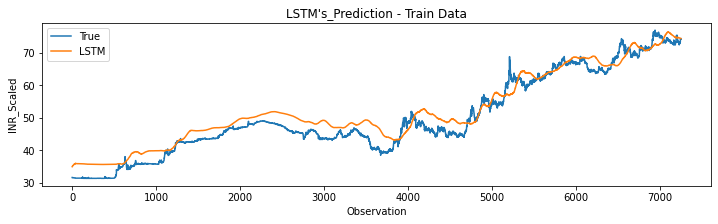

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(iy_train, label='True')
plt.plot(y_train_pred_lstm, label='LSTM')
plt.title("LSTM's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# Prediction the future data

In [ ]:
# Extracting the data to be fed for future predictions

x_input=np.array(data3[len(data3)-size:]).reshape(1,size)
print(x_input.shape,'\n')
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(len(temp_input))
temp_input[:5]

(1, 176) 

176


[0.9557052752293577,
 0.9567087155963304,
 0.9522649082568807,
 0.9604357798165136,
 0.9637327981651377]

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array
print(len(temp_input))
lst_output=[]
n_steps=size
i=0
while(i<300):
    
    if(len(temp_input)>size):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        # x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1,1, n_steps))
        # print(x_input)
        yhat = model_lstm.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape(1,1,n_steps)
        # print(x_input)
        yhat = model_lstm.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

176
[[0.9626818299293518], [0.9627012014389038], [0.9626163840293884], [0.9626019597053528], [0.9621675610542297], [0.9616149067878723], [0.9612561464309692], [0.96163409948349], [0.9612641930580139], [0.9606391191482544], [0.9608725905418396], [0.9613224864006042], [0.9616400599479675], [0.961402952671051], [0.9616856575012207], [0.9615756273269653], [0.9609957337379456], [0.9610413908958435], [0.9608024954795837], [0.9610013365745544], [0.9613557457923889], [0.961402952671051], [0.9612526297569275], [0.9609928131103516], [0.9609153866767883], [0.9607582092285156], [0.9610373973846436], [0.9608289003372192], [0.9605789184570312], [0.960938036441803], [0.9609630703926086], [0.960920512676239], [0.9605856537818909], [0.9601974487304688], [0.9597504138946533], [0.9600915908813477], [0.9594835042953491], [0.9594070911407471], [0.9596795439720154], [0.9590066075325012], [0.9588010311126709], [0.9586914777755737], [0.9578425884246826], [0.9581215381622314], [0.9582937359809875], [0.95781499

# plotting the final predicted along side the previous values

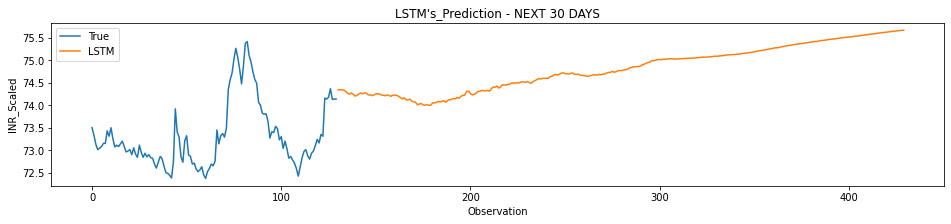

In [ ]:

day_pred=np.arange(130,130+300)
plt.figure(figsize=(16, 3))
plt.plot(iy_train[7431-size-130:], label='True')
plt.plot(day_pred,scaler.inverse_transform(lst_output), label='LSTM')
plt.title("LSTM's_Prediction - NEXT 30 DAYS")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [ ]:
print('PREDICTED VALUES FOR NEXT 30 DAYS')
print('--------------------------------\n')
result = scaler.inverse_transform(lst_output)
# for i in range(len(lst_output)):
# for x in result:
#   print(x, sep = ', ' )
print(result)

PREDICTED VALUES FOR NEXT 30 DAYS
--------------------------------

[[74.34668446]
 [74.34803581]
 [74.34211895]
 [74.34111271]
 [74.31080906]
 [74.2722559 ]
 [74.24722878]
 [74.27359478]
 [74.24779011]
 [74.20418495]
 [74.22047192]
 [74.25185665]
 [74.27401058]
 [74.25746998]
 [74.27719147]
 [74.26951576]
 [74.22906239]
 [74.23224743]
 [74.21558208]
 [74.22945324]
 [74.25417683]
 [74.25746998]
 [74.24698345]
 [74.22885864]
 [74.22345737]
 [74.21249268]
 [74.23196884]
 [74.21742409]
 [74.19998535]
 [74.22503742]
 [74.22678379]
 [74.22381496]
 [74.20045521]
 [74.17337402]
 [74.14218887]
 [74.16598938]
 [74.12356926]
 [74.11823868]
 [74.13724499]
 [74.09030094]
 [74.07595993]
 [74.06831749]
 [74.00909897]
 [74.0285585 ]
 [74.04057102]
 [74.00717381]
 [74.00123615]
 [74.01198879]
 [74.00023823]
 [73.99847107]
 [74.05373116]
 [74.05235069]
 [74.06428421]
 [74.08647972]
 [74.07328632]
 [74.09010136]
 [74.10268768]
 [74.06716156]
 [74.11045902]
 [74.12338215]
 [74.13228031]
 [74.15012238]
 [